## Objective

**Cryptocurrency prediction experiment** to predict direction of the close price of BTCUSDT for the next 1 hour

Dataset:
- BTCUSDT 1h in Json format from Binance

Prediction target logic:
- Set treshold to +-1%
- If next 1 hour close price is higher than 1% of current close price, label as 1
- If next 1 hour close price is lower than -1% of current close price, label as -1
- Else label as 0

Since we focus on the direction of the price, we will use classification model for this experiment

In [1]:
import pandas as pd

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

    # change datetime to index
    df.set_index('datetime', inplace=True)
    
    df = remove_outlier(df)
    return df

random_state = 55

## Feature Engineering

In [20]:
df = read_hist_data(name = 'BTC', timeframe = '1h') # read data
# df = read_hist_data(name = 'BTC', timeframe = '5m') # read data

# prediction target = close % change
df['target_pct'] = df['close'].pct_change()

print(df.head(10))
print(df.tail(10)) 



df.describe()

                         open      high       low     close       volume  \
datetime                                                                   
2021-01-01 00:00:00  28923.63  29031.34  28690.17  28995.13  2311.811445   
2021-01-01 01:00:00  28995.13  29470.00  28960.35  29409.99  5403.068471   
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29194.65  2384.231560   
2021-01-01 03:00:00  29195.25  29367.00  29150.02  29278.40  1461.345077   
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29220.31  2038.046803   
2021-01-01 05:00:00  29220.31  29235.28  29084.11  29187.01  1469.956262   
2021-01-01 06:00:00  29187.01  29270.00  29077.32  29174.35  1420.726291   
2021-01-01 07:00:00  29174.35  29191.98  28806.54  29092.83  2380.180918   
2021-01-01 08:00:00  29092.84  29178.03  28872.24  29000.01  2008.165739   
2021-01-01 09:00:00  29000.01  29307.73  28970.00  29202.21  2022.056022   

                     target_pct  
datetime                         
2021-01-01 00:00:00

,open,high,low,close,volume,target_pct
count,22915.000000,22915.000000,22915.000000,22915.000000,22915.000000,22914.000000
mean,35117.336473,35297.705123,34928.163154,35117.620848,4477.749672,0.000023
std,13125.131469,13210.580569,13033.198250,13125.379765,4697.700455,0.007451
min,15648.230000,15769.990000,15476.000000,15649.520000,5.887034,-0.105017
25%,23415.510000,23483.855000,23341.975000,23414.470000,1398.628235,-0.002710
50%,32099.970000,32345.000000,31800.000000,32099.980000,2658.617538,0.000025
75%,45197.645000,45485.530000,44869.145000,45197.975000,5828.032940,0.002775
max,68635.120000,69000.000000,68451.190000,68633.690000,28721.893750,0.123159


### Experiment 1: Create features from indicators

Use TAlib (Technical Analysis Library) in Python to create technical indicators that might have prediction power.
- Set `target` by using 25% level of target population as a threshold to determine direction of the price
- We will explore all available data which is Open, High, Low, Close, Volume
- We will focus in index type indicators since it's more generalizable to other stocks


In [2]:
import numpy as np
import pandas as pd

# to predict if the price will go up or down in the next period
def get_target_next_close(df, target_shift = 1):

    target_threshold = 0.003

    # future pct change of Close
    df['target_pct'] = df['close'].pct_change()
    
    # shift target in future by target_shift
    df['target_pct'] = df['target_pct'].shift(target_shift * -1)
   
    conditions = [
        (df['close'].shift(target_shift * -1).isnull()), 
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_threshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_threshold))
    ]
    values = [np.nan, 1, -1]
    df['target'] = np.select(conditions, values, default=0)
    
    return df

# df = read_hist_data()
# df = get_target_next_close(df)

# print(df.head(5))
# print(df.tail(5))

The features are derived from various technical indicators, such as the percentage of change, Exponential Moving Averages (EMA), Relative Strength Index (RSI), and others over multiple periods. The features are calculated using the `ta` library.

In [3]:
import talib
import numpy as np
import warnings

def get_features(df):
    df = df.copy()

    # List of periods
    periods = [5, 10, 20, 40, 80]
    inputs = ['open', 'high', 'low', 'close', 'volume']

    # log volume
    df['volume'] = np.log(df['volume'])
    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
        
        
            # Generate indicators

            # % of change
            df.loc[:, f'{input}_pct_{period}'] = df[input].pct_change(periods=period)

            # EMAs
            df.loc[:, f'{input}_ema_{period}'] = talib.EMA(df[input].values, timeperiod=period)

            # RSI
            df.loc[:, f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df.loc[:, f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            df.loc[:, f'{input}_sd_{period}'] = talib.STDDEV(df[input].values, timeperiod=period)

            # ROC
            df.loc[:, f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df.loc[:, f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)


        df = df.copy()
        
        # Multiple inputs indicators
        # ATR
        atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df.loc[:, f'price_atr_{period}'] = atr

        # Price interaction Features:
        df.loc[:, f'price_interact_{period}'] = df[f'close_pct_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df.loc[:, f'pv_interact_{period}'] = df[f'close_pct_{period}'] * df[f'volume_pct_{period}']

        # ADX
        df.loc[:, f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df.loc[:, f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df.loc[:, f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

    df = df.copy()
    
    return df

df = read_hist_data()
df = get_target_next_close(df)
df = get_features(df)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

# Count target values
print("Count", df['target'].value_counts())

print("Shape", df.shape)

df.describe()

Count target
 0.0    12098
 1.0     5335
-1.0     5243
Name: count, dtype: int64
Shape (22676, 212)


,open,high,low,close,volume,target_pct,target,open_pct_5,open_ema_5,open_rsi_5,...,volume_trix_80,volume_sd_80,volume_roc_80,volume_var_80,price_atr_80,price_interact_80,pv_interact_80,price_adx_80,mfi_80,price_dx_80
count,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,...,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000
mean,35119.474608,35297.924274,34932.766292,35119.358703,7.956264,0.000010,0.004057,0.000048,35120.544755,50.107491,...,-0.000756,0.507078,0.527117,0.271079,369.674408,-1.122671,-0.000306,13.488741,50.222947,13.596653
std,13187.442326,13273.257147,13095.169048,13187.740972,0.947552,0.007358,0.683000,0.016292,13183.542564,18.947606,...,0.029637,0.118117,11.124851,0.131423,240.670289,35.640334,0.007603,6.115836,5.729443,10.640867
min,15648.230000,15769.990000,15476.000000,15649.520000,1.772752,-0.105017,-1.000000,-0.139675,15735.204649,1.121960,...,-0.142974,0.271230,-77.445199,0.073566,37.364503,-317.718029,-0.097869,3.709515,31.638686,0.000563
25%,23358.705000,23439.325000,23269.340000,23355.080000,7.235698,-0.002691,0.000000,-0.006021,23365.200187,36.863903,...,-0.018797,0.415276,-6.567653,0.172454,162.803224,-9.242100,-0.001890,9.130853,46.185918,5.343820
50%,31883.545000,32163.280000,31671.145000,31881.755000,7.877857,0.000021,0.000000,0.000005,31941.809892,50.137025,...,-0.001035,0.483974,-0.101862,0.234231,315.535000,-0.103217,-0.000005,11.921938,50.032979,11.197398
75%,45445.780000,45776.395000,45150.000000,45445.790000,8.670391,0.002747,0.000000,0.006117,45479.773576,63.247994,...,0.016359,0.586128,6.872177,0.343546,538.664388,10.468266,0.001707,16.205516,54.030398,19.276040
max,68635.120000,69000.000000,68451.190000,68633.690000,10.265415,0.123159,1.000000,0.185445,68225.516624,98.827914,...,0.124158,0.990415,330.676978,0.980922,1290.661348,227.240465,0.309765,40.244988,69.827068,74.174616


##### Identify the most important features

When dealing with a large number of features, it's crucial to determine which features are most relevant for predicting your target variable. Feature selection techniques can help you identify the most relevant features, reduce overfitting, improve accuracy, and reduce training time. We will use a **Tree-Based Model** to rank the importance of each feature.

**Sort importance of features of Close price change (Regression)**

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into train and test sets
drop_columns = ['target', 'target_pct']
X = df.drop(columns=drop_columns)
y = df['target_pct']

random_state = 55

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=55)

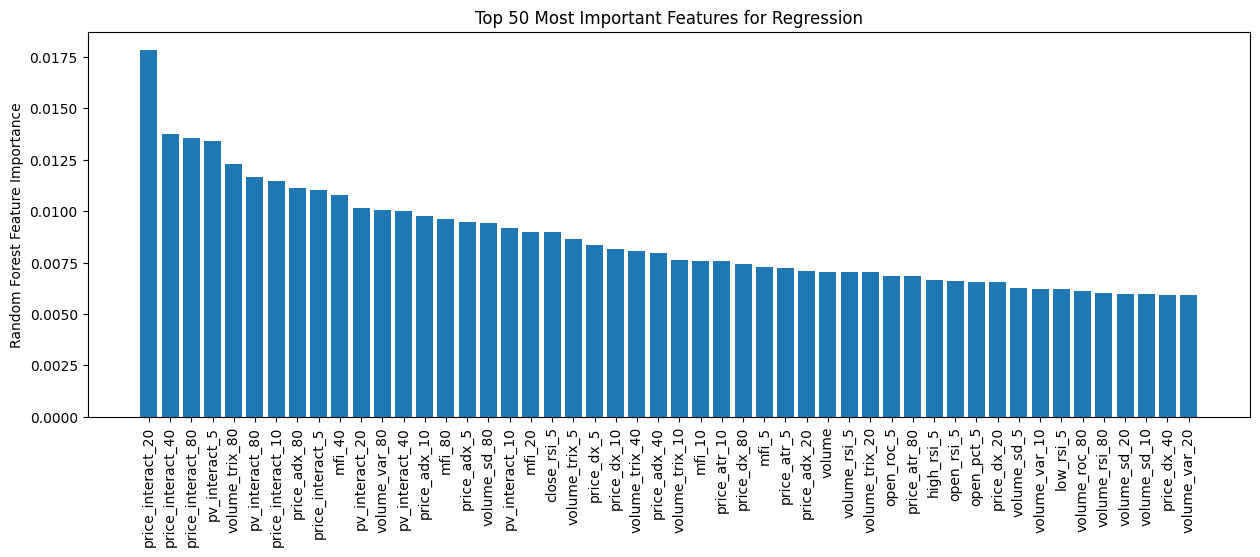

In [147]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]  # Reverse the sorting order

# Get top 50 features
top_50_indices = sorted_idx[:50]
top_50_importances = importances[top_50_indices]
top_50_features_regression = X.columns[top_50_indices]

plt.figure(figsize=(15, 5))
plt.bar(top_50_features_regression, top_50_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Top 50 Most Important Features for Regression")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

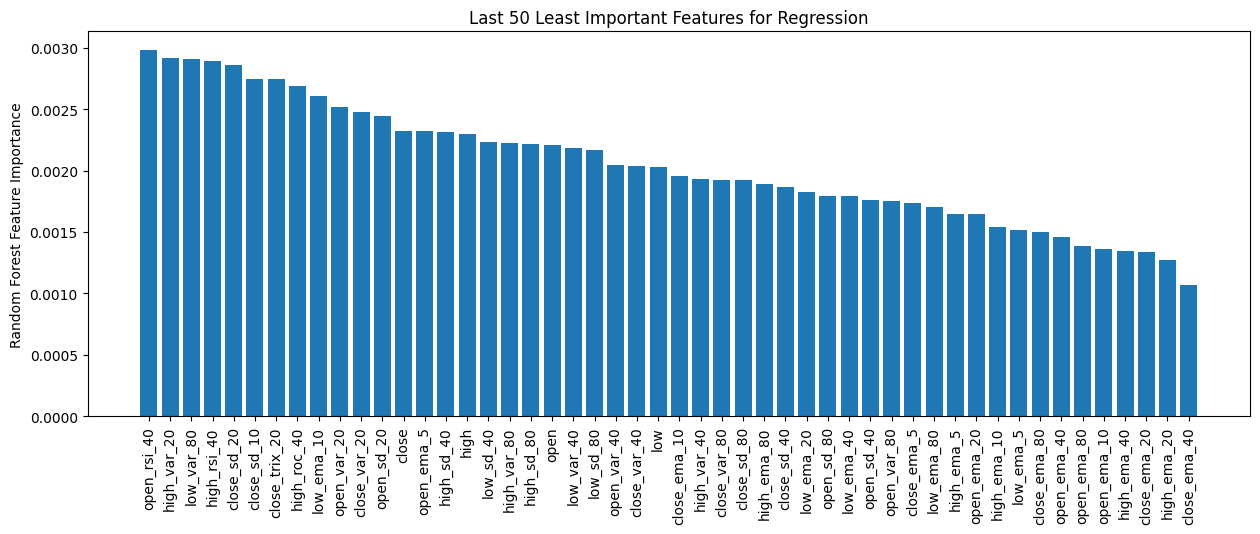

In [148]:
# Get last 50 features
last_50_indices = sorted_idx[-50:]
last_50_importances = importances[last_50_indices]
last_50_features_regression = X.columns[last_50_indices]

plt.figure(figsize=(15, 5))
plt.bar(last_50_features_regression, last_50_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Last 50 Least Important Features for Regression")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

In [149]:
# Evaluate model with mean_squared_error
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Regression - Mean Squared Error: {mse:.6f}")

Regression - Mean Squared Error: 0.000125


In [150]:
print("top_50_features_regression =", top_50_features_regression)
print("last_50_features_regression =",last_50_features_regression)

top_50_features_regression = Index(['price_interact_20', 'price_interact_40', 'price_interact_80',
       'pv_interact_5', 'volume_trix_80', 'pv_interact_80',
       'price_interact_10', 'price_adx_80', 'price_interact_5', 'mfi_40',
       'pv_interact_20', 'volume_var_80', 'pv_interact_40', 'price_adx_10',
       'mfi_80', 'price_adx_5', 'volume_sd_80', 'pv_interact_10', 'mfi_20',
       'close_rsi_5', 'volume_trix_5', 'price_dx_5', 'price_dx_10',
       'volume_trix_40', 'price_adx_40', 'volume_trix_10', 'mfi_10',
       'price_atr_10', 'price_dx_80', 'mfi_5', 'price_atr_5', 'price_adx_20',
       'volume', 'volume_rsi_5', 'volume_trix_20', 'open_roc_5',
       'price_atr_80', 'high_rsi_5', 'open_rsi_5', 'open_pct_5', 'price_dx_20',
       'volume_sd_5', 'volume_var_10', 'low_rsi_5', 'volume_roc_80',
       'volume_rsi_80', 'volume_sd_20', 'volume_sd_10', 'price_dx_40',
       'volume_var_20'],
      dtype='object')
last_50_features_regression = Index(['open_rsi_40', 'high_var_20', '

**Sort importance of features of Close price level (Classification)**

In [151]:
from sklearn.ensemble import RandomForestClassifier

# Pre data for classification
drop_columns = ['target', 'target_pct']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=55)

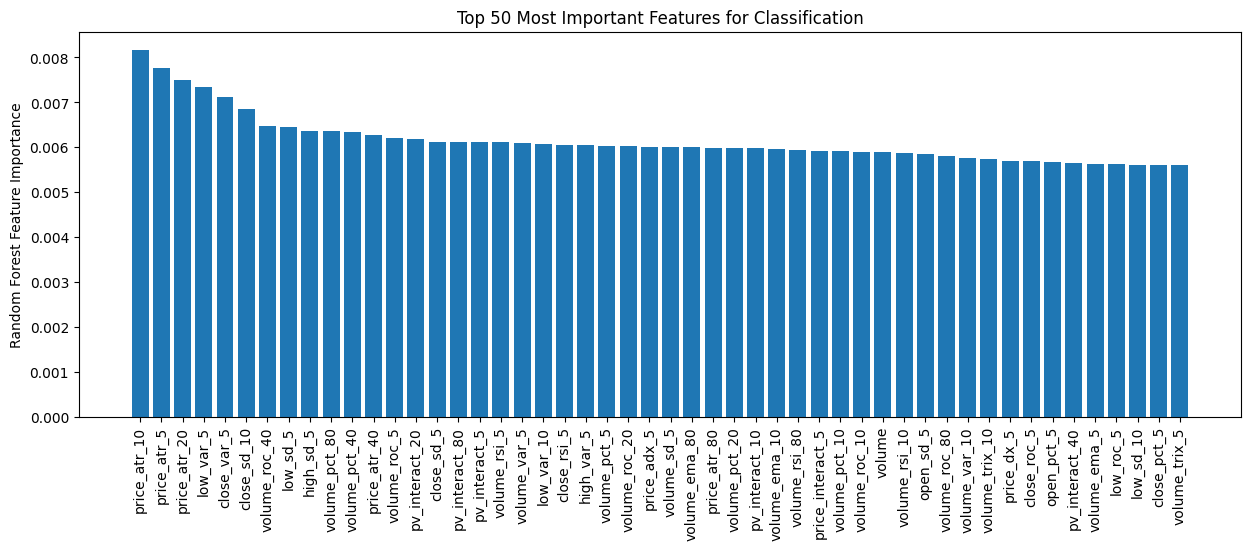

In [152]:
importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]  # Reverse the sorting order

# Get top 50 features
top_50_indices = sorted_idx[:50]
top_50_importances = importances[top_50_indices]
top_50_features_classification = X.columns[top_50_indices]

plt.figure(figsize=(15, 5))
plt.bar(top_50_features_classification, top_50_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Top 50 Most Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

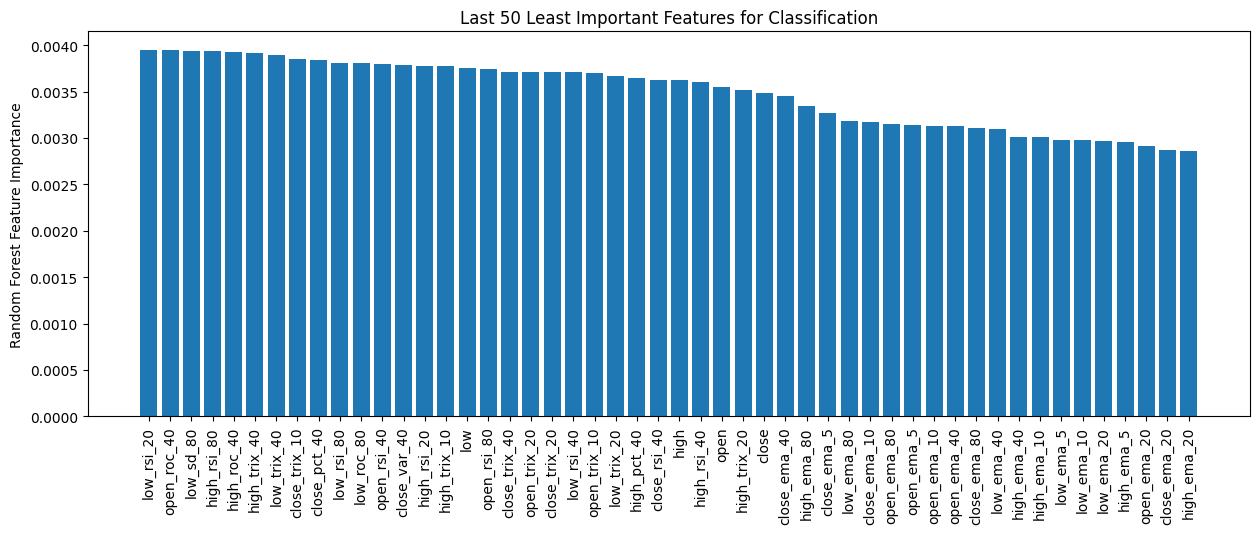

In [153]:
# Get last 50 features
last_50_indices = sorted_idx[-50:]
last_50_importances = importances[last_50_indices]
last_50_features_classification = X.columns[last_50_indices]

plt.figure(figsize=(15, 5))
plt.bar(last_50_features_classification, last_50_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Last 50 Least Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

In [154]:
print("top_50_features_classification =", top_50_features_classification)
print("last_50_features_classification =",last_50_features_classification)

top_50_features_classification = Index(['price_atr_10', 'price_atr_5', 'price_atr_20', 'low_var_5',
       'close_var_5', 'close_sd_10', 'volume_roc_40', 'low_sd_5', 'high_sd_5',
       'volume_pct_80', 'volume_pct_40', 'price_atr_40', 'volume_roc_5',
       'pv_interact_20', 'close_sd_5', 'pv_interact_80', 'pv_interact_5',
       'volume_rsi_5', 'volume_var_5', 'low_var_10', 'close_rsi_5',
       'high_var_5', 'volume_pct_5', 'volume_roc_20', 'price_adx_5',
       'volume_sd_5', 'volume_ema_80', 'price_atr_80', 'volume_pct_20',
       'pv_interact_10', 'volume_ema_10', 'volume_rsi_80', 'price_interact_5',
       'volume_pct_10', 'volume_roc_10', 'volume', 'volume_rsi_10',
       'open_sd_5', 'volume_roc_80', 'volume_var_10', 'volume_trix_10',
       'price_dx_5', 'close_roc_5', 'open_pct_5', 'pv_interact_40',
       'volume_ema_5', 'low_roc_5', 'low_sd_10', 'close_pct_5',
       'volume_trix_5'],
      dtype='object')
last_50_features_classification = Index(['low_rsi_20', 'open_roc_40

In [156]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average if classes are imbalanced
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:0.4f}")
print(f"F1-Score: {f1:0.4f}")
print(f"Precision: {precision:0.4f}")
print(f"Recall: {recall:0.4f}")

Accuracy: 0.6825
F1-Score: 0.6424
Precision: 0.6166
Recall: 0.6825


##### Features importance interpretation:

**Classification Model:**

**Objective**: The classification model aims to predict the level of return for the next hour. The three classes represent:
- **1**: An increase greater than a specified threshold.
- **-1**: A decrease greater than the threshold.
- **0**: Changes within the threshold.

**Model Performance**:
- **Accuracy**: 68.25%. This means that out of all the predictions made, about 68.25% were correct. 
- **F1-Score**: 64.24%. F1-Score is the harmonic mean of precision and recall, and a score of 64.24% suggests a balanced performance in terms of false positives and false negatives.
- **Precision**: 61.66%. This tells us that when the model predicts an increase or decrease, it's correct about 61.66% of the time.
- **Recall**: 68.25%. This suggests that of all actual price movements that should have been classified correctly, the model caught about 68.25% of them.

Key features for this model are primarily base on `price volatility` metrics (`price_atr_...`, `close_sd_...`, and `close_var_...`). The combined effects of price and volume movements (`pv_interact_...` and `volume_ema_...`) also appear to be significant predictors.

**Regression Model:**

**Objective**: The regression model predicts the continuous return for the next hour.

**Model Performance**:
- **Mean Squared Error (MSE)**: 0.000125, A low MSE suggests that the model's predictions are relatively close to the actual values. Without more context, it's hard to determine if this is a good MSE value, but in general, a lower MSE indicates better performance.

The top features for this model emphasize the importance of price interactions (`Close * ATR`) with various metrics (`price_interact_...`). The interactions of volume and price (`pv_interact_...`), along with specific metrics like `volume_trix_...` and `mfi_...`, play a significant role in predicting BTCUSDT returns.

**Summary:**
1. **Classification Model**: With an accuracy of nearly 70%, the model performs reasonably well in predicting the direction and magnitude of the next hour's return base on the threshold. The features that stand out are those related to price `volatility` and `interactions between volume and price`. 
   
2. **Regression Model**: The model's predictions are relatively close to actual returns, as indicated by the MSE. Key predictors include `price interactions` and `volume-price interactions`.

----

### Experiment 2: Pre-process the data

**Note:** 
- I will focus on `classification model` since the final goal is to create an indicator for trading strategy. 
- The indicator will be used to determine the direction of the price (up, down, no change).
- I already experimented with regression model with RNN [here](https://github.com/natapone/learning_ai_by_coding/blob/main/3-1_DL_fundamental.ipynb)

Pre-processing the data can often lead to better model performance.

- First, calcualte baseline metrics for the model performance
- Keep all features from experiment 1 to select later

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Pre data for classification
drop_columns = ['target', 'target_pct']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate base metrics
base_accuracy = accuracy_score(y_test, y_pred)
base_f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average if classes are imbalanced
base_precision = precision_score(y_test, y_pred, average='weighted')
base_recall = recall_score(y_test, y_pred, average='weighted')

print("Cassification base score")
print(f"Accuracy: {base_accuracy:0.4f}")
print(f"F1-Score: {base_f1:0.4f}")
print(f"Precision: {base_precision:0.4f}")
print(f"Recall: {base_recall:0.4f}")

Cassification based score
Accuracy: 0.6825
F1-Score: 0.6424
Precision: 0.6166
Recall: 0.6825


##### 1. Feature Scaling

**Standardization (Z-Score Normalization):** `StandardScaler`
- Transforms your data such that it has a mean of 0 and a standard deviation of 1. 
- This is useful for algorithms that assume features have a Gaussian distribution, e.g., SVM, Linear Regression.

**Normalization (Min-Max Scaling):** `MinMaxScaler`
- Rescale features to lie in a range [0, 1]. 
- This is beneficial for algorithms that use gradient descent or require features to be on the same scale, e.g., Neural Networks, KNN, Gradient Descent base algorithms.

I plan to test several models, I'll separate Scaling for different models


| **Model**               | **Brief Explanation**                                                                                                          | **Scaling Recommendation**                                        |
|------------------------|--------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------|
| **Random Forest**      | An ensemble method that creates multiple decision trees during training and outputs the class that is the mode of the classes (classification) or average prediction (regression) of the individual trees. | Not required (scale invariant).                                    |
| **Decision Tree**      | A tree-like model of decisions. It splits the source set into subsets base on the value of an input feature.                     | Not required (scale invariant).                                    |
| **K-Nearest Neighbors**| A non-parametric method used for classification and regression. It predicts base on the 'k' nearest training samples.            | Min-Max scaling.                                                   |
| **Logistic Regression**| A statistical model used for binary classification. It predicts the probability that a given instance belongs to a particular category. | Z-score normalization.                                             |
| **SVM linear**         | Support Vector Machine with a linear kernel. It finds a hyperplane that best separates the classes.                              | Z-score normalization.                                             |
| **SVM rbf**            | SVM with a radial basis function kernel. It can capture non-linear relationships.                                               | Z-score normalization.                                             |
| **Naive Bayes**        | A probabilistic classifier base on applying Bayes' theorem with strong (naive) independence assumptions between the features.       | Z-score normalization (optional).                                   |
| **Gradient Boosting**  | An ensemble technique where new models are added to correct the errors made by existing models. It builds trees one at a time, where each tree corrects errors of the preceding one. | Z-score or Min-Max normalization (optional).                       |
| **AdaBoost**           | An ensemble method that adjusts the weights of misclassified data points and builds multiple weak learners (typically decision trees), combining them for a final prediction.  | Z-score or Min-Max normalization (optional).                       |
| **LightGBM**           | A gradient boosting framework that uses tree-base algorithms, designed to be efficient and distributed. It's known for its speed and efficiency. | Z-score normalization (optional).                                   |


**Z-Score Normalization**

In [6]:
from sklearn.preprocessing import StandardScaler
scaler_std = StandardScaler()

# Fit the scaler using the training data
X_train_scale_std = scaler_std.fit_transform(X_train)
X_test_scale_std = scaler_std.transform(X_test)

**Min-Max Scaling**

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()

# Fit the scaler using the training data
X_train_scale_mm = scaler_mm.fit_transform(X_train)
X_test_scale_mm = scaler_mm.transform(X_test)

##### 2. Imbalance data

The dataset appears to have a class imbalance, especially when comparing the count of class `0` to classes `+1` and `-1`. Handling imbalanced datasets can be important, as it can help improve the performance of a classifier, especially for the minority classes.

For this experiment, 
- I will use the `imbalanced-learn` library to apply the Synthetic Minority Oversampling Technique (SMOTE) to the training set. 
- `Oversampling`: Increase the number of instances in the minority class by duplicating samples or generating synthetic samples.

In [8]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=random_state)

# Z-Score Normalization
X_train_std_sm, y_train_std_sm = sm.fit_resample(X_train_scale_std, y_train)

# Min-Max Scaling
X_train_mm_sm, y_train_mm_sm = sm.fit_resample(X_train_scale_mm, y_train)

Summary of pre-processed dataset:

| Dataset Name           | Feature Scaling   | Resampling |
|------------------------|-------------------|------------|
| X_train, y_train, X_test, y_test       | None              | None       |
| X_train_scale_std, y_train, X_test_scale_std, y_test | StandardScaler | None       |
| X_train_scale_mm, y_train, X_test_scale_mm, y_test | MinMaxScaler   | None       |
| X_train_std_sm, y_train_std_sm, X_test_scale_std, y_test | StandardScaler | SMOTE   |
| X_train_mm_sm, y_train_mm_sm, X_test_scale_mm, y_test  | MinMaxScaler | SMOTE   |

##### Evaluate datasets with baseline model

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# Setting a random state for reproducibility
random_state = 55

# Define the datasets
datasets = {
    "no_scale_no_SMOTE": (X_train, y_train, X_test, y_test),
    "StandardScaler_no_SMOTE": (X_train_scale_std, y_train, X_test_scale_std, y_test),
    "MinMaxScaler_no_SMOTE": (X_train_scale_mm, y_train, X_test_scale_mm, y_test),
    "StandardScaler_SMOTE": (X_train_std_sm, y_train_std_sm, X_test_scale_std, y_test),
    "MinMaxScaler_SMOTE": (X_train_mm_sm, y_train_mm_sm, X_test_scale_mm, y_test)
}

# Base model
model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)

# Evaluation metrics dictionary with the 'weighted' average for multiclass classification
metrics = {
    "Accuracy": accuracy_score,
    "F1-Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')
}

# To store results
results = {}

for dataset_name, (iX_train, iy_train, iX_test, iy_test) in datasets.items():
    print(f"Training on {dataset_name}...")
    
    # Fit model
    model.fit(iX_train, iy_train)
    
    # Predict on test set (assuming you have a separate test set, X_test, y_test)
    y_pred = model.predict(iX_test)
    
    # Compute and store metrics
    results[dataset_name] = {}
    for metric_name, metric_func in metrics.items():
        results[dataset_name][metric_name] = metric_func(iy_test, y_pred)

# Display the results
for dataset_name, metrics_results in results.items():
    print("\nResults for:", dataset_name)
    for metric_name, metric_value in metrics_results.items():
        print(f"{metric_name}: {metric_value:.4f}")


Training on no_scale_no_SMOTE...
Training on StandardScaler_no_SMOTE...
Training on MinMaxScaler_no_SMOTE...
Training on StandardScaler_SMOTE...
Training on MinMaxScaler_SMOTE...

Results for: no_scale_no_SMOTE
Accuracy: 0.6825
F1-Score: 0.6424
Precision: 0.6166
Recall: 0.6825

Results for: StandardScaler_no_SMOTE
Accuracy: 0.6841
F1-Score: 0.6441
Precision: 0.6186
Recall: 0.6841

Results for: MinMaxScaler_no_SMOTE
Accuracy: 0.6847
F1-Score: 0.6464
Precision: 0.6220
Recall: 0.6847

Results for: StandardScaler_SMOTE
Accuracy: 0.6868
F1-Score: 0.6524
Precision: 0.6300
Recall: 0.6868

Results for: MinMaxScaler_SMOTE
Accuracy: 0.6925
F1-Score: 0.6570
Precision: 0.6346
Recall: 0.6925


**Observations:**

1. **Effect of Scaling**: The Random Forest classifier, in theory, `doesn't require feature scaling`, and it's evident from the results as the accuracy and other metrics for non-scaled data are in the same ballpark as the scaled datasets. However, there's a `slight improvement` in the models with scaled data (both StandardScaler and MinMaxScaler).

2. **Effect of SMOTE**: Using the SMOTE technique to handle class imbalance seems to have a positive effect on the performance of the model. Both the StandardScaler_SMOTE and MinMaxScaler_SMOTE datasets show a `better performance` compared to their non-SMOTE counterparts. The improvement isn't drastic, but it's noticeable. This indicates that handling class imbalance is beneficial for this particular problem and dataset.

3. **Choice of Scaling Method**: Between StandardScaler and MinMaxScaler, the differences in model performance are minimal. However, when combined with SMOTE, MinMaxScaler shows a slightly better result in all metrics compared to StandardScaler.

4. **Best Overall Dataset for Training**: The dataset processed with MinMaxScaler followed by SMOTE oversampling (`MinMaxScaler_SMOTE`) produces the best performance in all the metrics among all datasets.

5. **Metrics Consistency**: The Recall matches the Accuracy for each dataset. This is an interesting observation, suggesting that for these particular splits of data and the chosen model, the number of True Positives and True Negatives dominates the False Positives and False Negatives.


----

### Experiment 3: Test alternative models

A brief summary of the ML models:

| Model                  | Use Case                                                                                   | Pros                                                                                                           | Cons                                                                             |
|------------------------|--------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Random Forest (Baseline)**  | - Classification and Regression<br>- Feature importance                                   | - Handles categorical & numerical data<br>- Less prone to overfitting compared to single trees<br>- Can capture non-linear relationships | - Can be slow on large datasets<br>- More complex and harder to visually interpret compared to single trees |
| **Logistic Regression**    | - Binary/Multi-class classification<br>- Probability estimation                           | - Simple and interpretable<br>- Fast training times<br>- Good for linearly separable data                      | - Assumes linear decision boundary<br>- Not suited for non-linear relationships   |
| **SVM (rbf)**           | - Classification in non-linear spaces<br>- Regression in non-linear spaces                 | - Effective in high-dimensional spaces<br>- Can capture non-linear relationships with kernel trick            | - Slow training time for large datasets<br>- Sensitive to hyperparameters          |
| **Decision Tree**          | - Classification and Regression<br>- Decision-making scenarios                            | - Easy to interpret and visualize<br>- Handles both numerical and categorical data                           | - Prone to overfitting<br>- Sensitive to small data variations                    |
| **K-Nearest Neighbors**   | - Classification based on similarity<br>- Regression based on similarity                  | - Simple and intuitive<br>- No training phase, instance-based                                                | - Computationally intensive during testing<br>- Sensitive to irrelevant features   |
| **Naive Bayes**            | - Text classification<br>- Spam detection<br>- Sentiment analysis                         | - Simple and fast<br>- Performs well with high-dimensional datasets                                         | - Assumes feature independence (often not true in practice)<br>- Might not perform well with less training data |
| **Gradient Boosting**     | - Classification and Regression<br>- Ranking                                              | - Can capture non-linear relationships<br>- Often provides high accuracy                                     | - Sensitive to overfitting with noisy data<br>- Longer training times              |
| **AdaBoost**               | - Classification with weak learners<br>- Feature selection                                | - Simple and adaptive<br>- Less prone to overfitting                                                        | - Sensitive to noisy data and outliers<br>- Might be slower than other boosting algorithms   |
| **LightGBM**               | - Large-scale Classification and Regression<br>- Ranking                                  | - Faster training and more efficient than traditional GBM<br>- Supports categorical features directly        | - More complex and might be overkill for small datasets<br>- Many hyperparameters to tune |


In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import time

# Define classifiers
classifiers = {
    "Random Forest (Baseline)": RandomForestClassifier(random_state=random_state, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1),
    "SVM rbf": SVC(kernel='rbf', random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    'LightGBM': lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1),
}

# Datasets
datasets = {
    "no_scale_no_SMOTE": (X_train, y_train, X_test, y_test),
    "StandardScaler_no_SMOTE": (X_train_scale_std, y_train, X_test_scale_std, y_test),
    "MinMaxScaler_no_SMOTE": (X_train_scale_mm, y_train, X_test_scale_mm, y_test),
    "StandardScaler_SMOTE": (X_train_std_sm, y_train_std_sm, X_test_scale_std, y_test),
    "MinMaxScaler_SMOTE": (X_train_mm_sm, y_train_mm_sm, X_test_scale_mm, y_test)
}

results = {}

for dataset_name, (iX_train, iy_train, iX_test, iy_test) in datasets.items():
    for classifier_name, classifier in classifiers.items():
        # Calculate execute start time
        start = time.time()
        
        print(f"Training {classifier_name} on {dataset_name}...", end=" ")

        try:
            # Train the model
            model = classifier
            model.fit(iX_train, iy_train)
            y_pred = model.predict(iX_test)
            
            # Compute metrics
            accuracy = accuracy_score(iy_test, y_pred)
            f1 = f1_score(iy_test, y_pred, average='weighted')
            precision = precision_score(iy_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(iy_test, y_pred, average='weighted')
        except Exception as e:
            # print(f"Error: {e}")
            accuracy = 0
            f1 = 0
            precision = 0
            recall = 0
        
        # Save results
        results[(dataset_name, classifier_name)] = {
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Precision': precision,
            'Recall': recall
        }

        # Calculate execute duration
        duration = time.time() - start
        print(f"- Duration: {duration/60:.2f} minutes")

print("\nDone!\n")
# Print results
for (dataset_name, classifier_name), metrics in results.items():
    print(f"Results for {classifier_name} with {dataset_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    print("=====================================")


Training Random Forest (Baseline) on no_scale_no_SMOTE... - Duration: 0.03 minutes
Training Logistic Regression on no_scale_no_SMOTE... - Duration: 0.82 minutes
Training SVM rbf on no_scale_no_SMOTE... - Duration: 0.44 minutes
Training Decision Tree on no_scale_no_SMOTE... - Duration: 0.07 minutes
Training K-Nearest Neighbors on no_scale_no_SMOTE... - Duration: 0.00 minutes
Training Naive Bayes on no_scale_no_SMOTE... - Duration: 0.00 minutes
Training Gradient Boosting on no_scale_no_SMOTE... - Duration: 4.50 minutes
Training AdaBoost on no_scale_no_SMOTE... - Duration: 0.30 minutes
Training LightGBM on no_scale_no_SMOTE... - Duration: 0.04 minutes
Training Random Forest (Baseline) on StandardScaler_no_SMOTE... - Duration: 0.03 minutes
Training Logistic Regression on StandardScaler_no_SMOTE... - Duration: 0.11 minutes
Training SVM rbf on StandardScaler_no_SMOTE... - Duration: 0.44 minutes
Training Decision Tree on StandardScaler_no_SMOTE... - Duration: 0.07 minutes
Training K-Nearest N

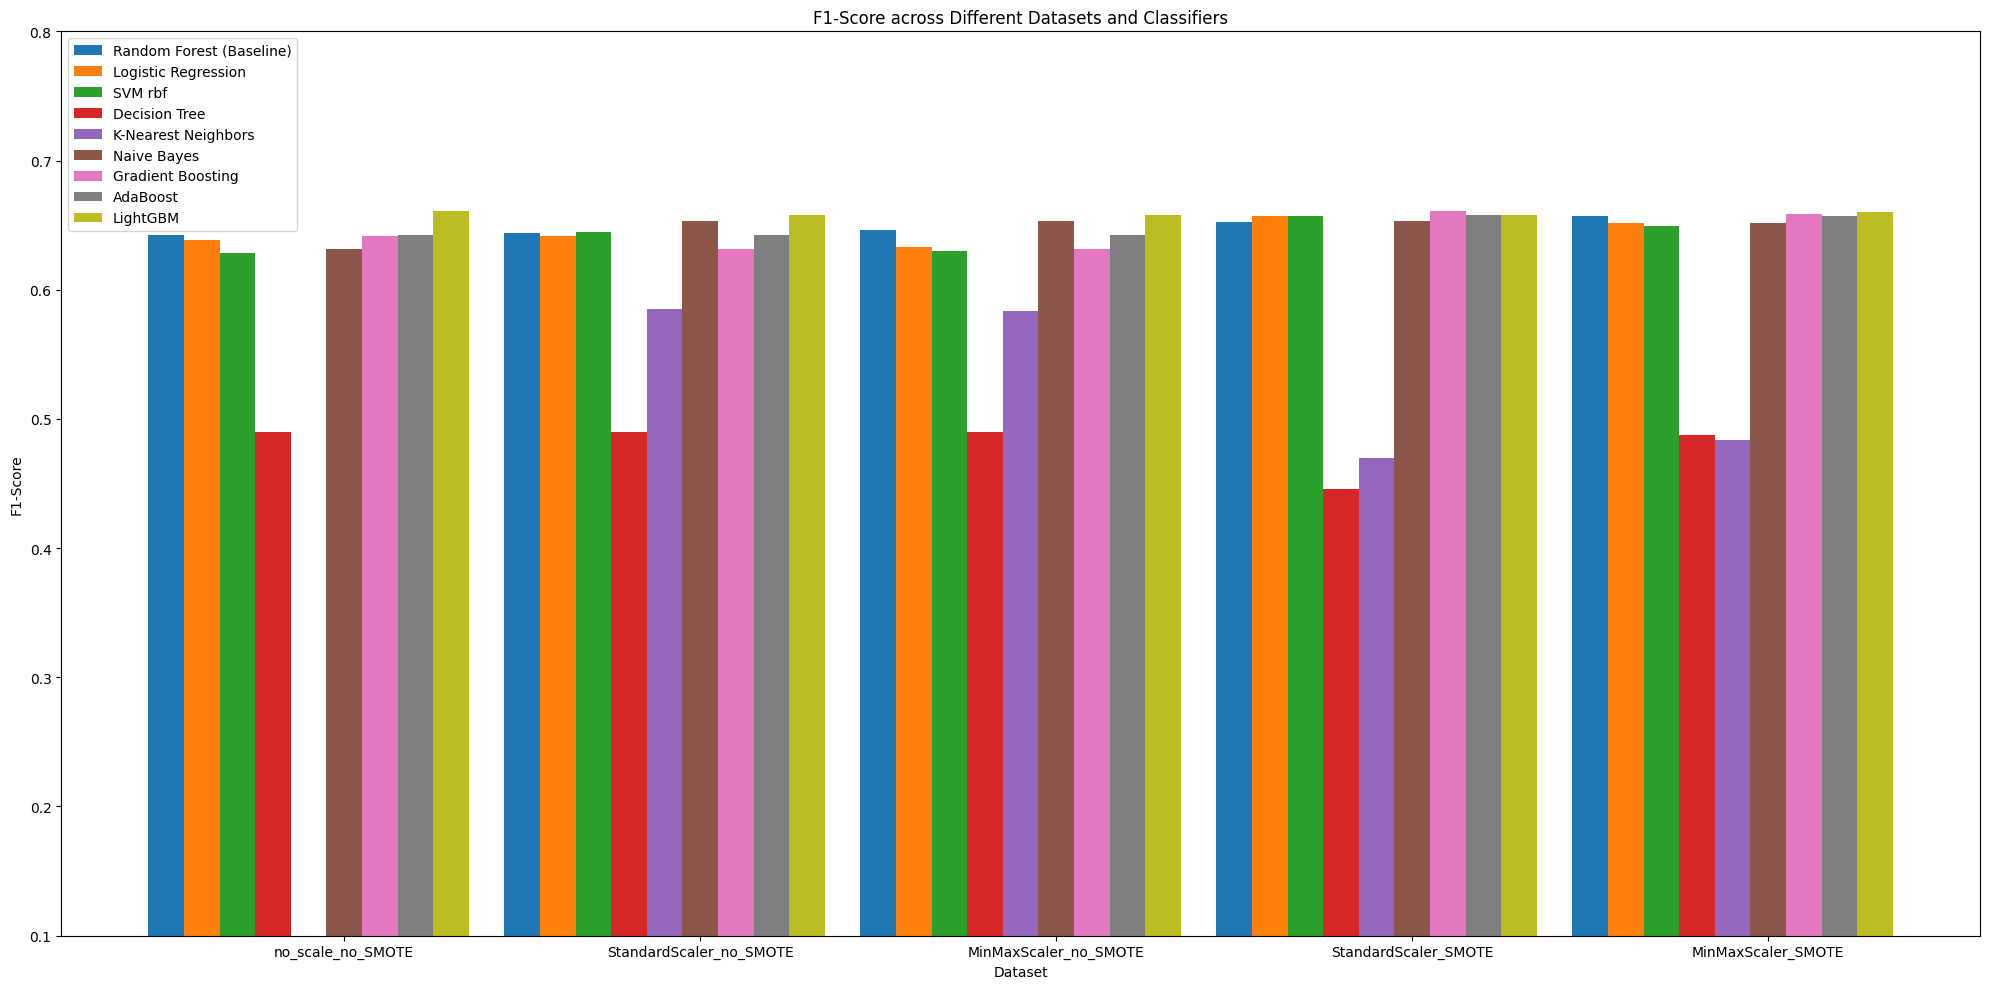

In [12]:
import matplotlib.pyplot as plt

# Extract F1-Scores from the results
f1_scores = {}
for (dataset_name, classifier_name), metrics in results.items():
    if classifier_name not in f1_scores:
        f1_scores[classifier_name] = {}
    f1_scores[classifier_name][dataset_name] = metrics['F1-Score']

# Plot F1-Scores
plt.figure(figsize=(20,10))

# List of classifier names
classifier_names = list(f1_scores.keys())

# Generate bar positions
bar_positions = list(range(len(datasets)))

# For each classifier, plot a bar for each dataset
for idx, (classifier_name, scores) in enumerate(f1_scores.items()):
    plt.bar([pos + 0.1 * idx for pos in bar_positions], scores.values(), width=0.1, label=classifier_name)

# increase x height
plt.ylim(0.1, 0.8)

plt.xlabel('Dataset')
plt.ylabel('F1-Score')
plt.title('F1-Score across Different Datasets and Classifiers')
plt.xticks([pos + 0.5 for pos in bar_positions], list(datasets.keys()))
plt.legend()
plt.tight_layout()
plt.show()


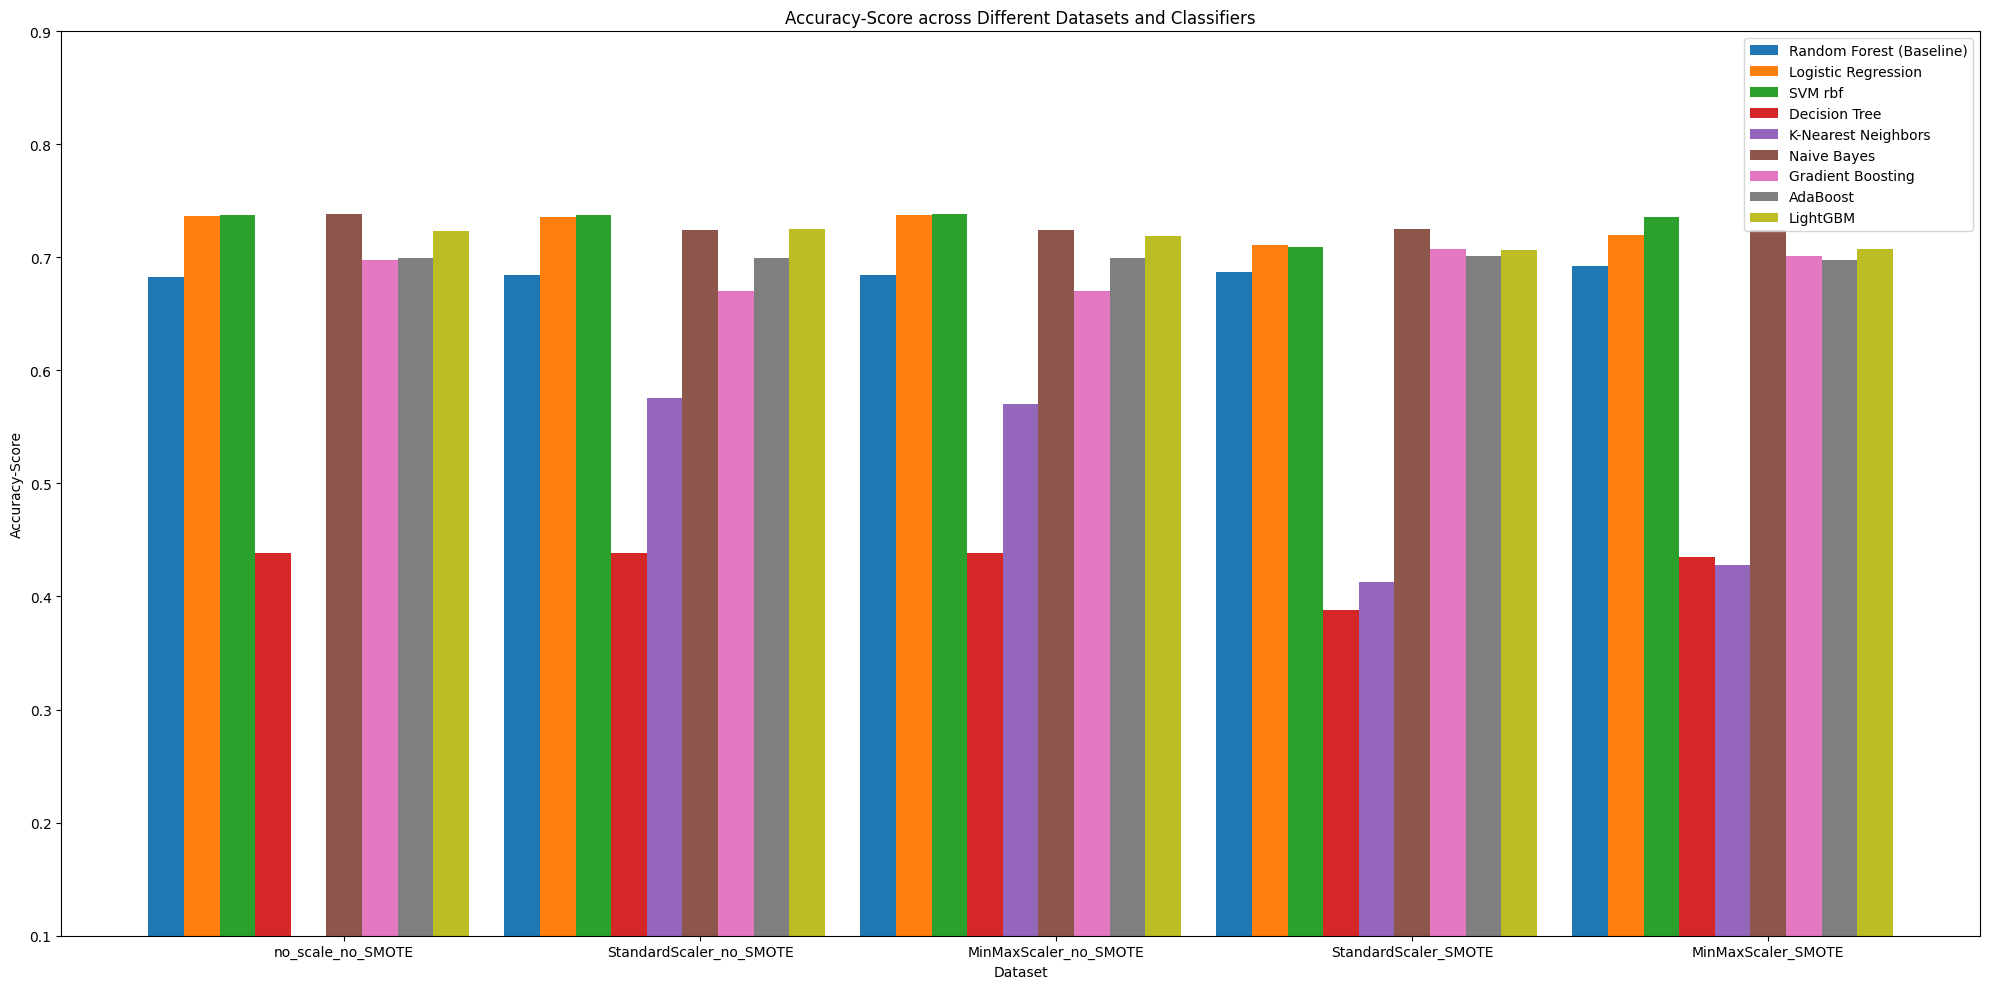

In [16]:
import matplotlib.pyplot as plt

# Extract accuracy-Scores from the results
accuracy_scores = {}
for (dataset_name, classifier_name), metrics in results.items():
    if classifier_name not in accuracy_scores:
        accuracy_scores[classifier_name] = {}
    accuracy_scores[classifier_name][dataset_name] = metrics['Accuracy']

# Plot Accuracy-Scores
plt.figure(figsize=(20,10))

# List of classifier names
classifier_names = list(accuracy_scores.keys())

# Generate bar positions
bar_positions = list(range(len(datasets)))

# For each classifier, plot a bar for each dataset
for idx, (classifier_name, scores) in enumerate(accuracy_scores.items()):
    plt.bar([pos + 0.1 * idx for pos in bar_positions], scores.values(), width=0.1, label=classifier_name)

# increase x height
plt.ylim(0.1, 0.9)

plt.xlabel('Dataset')
plt.ylabel('Accuracy-Score')
plt.title('Accuracy-Score across Different Datasets and Classifiers')
plt.xticks([pos + 0.5 for pos in bar_positions], list(datasets.keys()))
plt.legend()
plt.tight_layout()
plt.show()


**Foe next experimant:**

Given that the Decision Tree and K-Nearest Neighbors performed poorly in the previous experiment, it makes sense to drop them for further evaluation. 
The MinMaxScaler_SMOTE dataset transformation worked best overall, it will be use for the next set of experiments.

1. **Data Preparation**:
   - Use the `MinMaxScaler_SMOTE` transformation method to preprocess dataset. The MinMaxScaler will scale the features such that they will have values between 0 and 1, while SMOTE (Synthetic Minority Over-sampling Technique) will address class imbalance by generating synthetic samples for the minority class.

2. **Model Selection**:
   - Drop `Decision Tree` and `K-Nearest Neighbors`, focusing on the other algorithms.

3. **Ensemble Methods**:

   - Using these ensemble methods, we could potentially increase the predictive power by combining the strengths of the top-performing individual classifiers.

----

### Experiment 4: Ensemble Methods

We focus on using ensemble methods to combine the predictions of multiple models especially Bagging and Stacking. However, they work best under different conditions and serve different purposes.

##### Bagging:
- **Strengths**: It can reduce overfitting by creating an ensemble of parallel models.
- **Weaknesses**: All base models are of the same type and are trained on different subsets of the training data.
- **Use Case**: Effective when the base model has high variance (like Decision Trees). Bagging can help reduce overfitting and variance by averaging predictions.
  
##### Stacking:
- **Strengths**: Can capture complex patterns by combining predictions from diverse model types, improving the model's performance.
- **Weaknesses**: More computationally expensive and can be prone to overfitting if not carefully tuned.
- **Use Case**: Effective for models with complementary strengths and weaknesses.

##### Implementation
- **For Bagging:** We will use the **RandomForestClassifier** as the base model.
- **For Stacking:** We will stack the rest of models and new Bagging model as the base model.

#### Base models:

In [23]:
# Rewrite pre-processing steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Pre data for classification
drop_columns = ['target', 'target_pct']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

scaler = MinMaxScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

sm = SMOTE(random_state=random_state)

# Min-Max Scaling
X_train_pre, y_train_pre = sm.fit_resample(X_train_pre, y_train)

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import time

##### Bagging with RandomForest

In [48]:
# Randon Forest Baseline model
time_start = time.time()
model_rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

# Fit model and predict
model_rf.fit(X_train_pre, y_train_pre)
y_pred = model_rf.predict(X_test_pre)

# F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"Random Forest (Baseline) F1-Score: {f1:.4f}")
print(f"Random Forest (Baseline) Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Random Forest (Baseline) F1-Score: 0.6570
Random Forest (Baseline) Accuracy: 0.6925
Duration: 0.04 minutes


In [49]:
# Bagging Random Forest model
time_start = time.time()
model_bagging_rf = BaggingClassifier(estimator=model_rf, 
                    random_state=random_state, n_jobs=-1)

model_bagging_rf.fit(X_train_pre, y_train_pre)
y_pred = model_bagging_rf.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"Bagging Random Forest F1-Score: {f1:.4f}")
print(f"Bagging Random Forest Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Bagging Random Forest F1-Score: 0.6651
Bagging Random Forest Accuracy: 0.7189
Duration: 0.25 minutes


There's a slight improvement in the model's performance after applying the Bagging technique. The F1-Score and accuracy increased around 1% and 2.6%, respectively. 

##### Logistic Regression

In [50]:
time_start = time.time()
model_lr = LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1)

model_lr.fit(X_train_pre, y_train_pre)
y_pred = model_lr.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"Logistic Regression F1-Score: {f1:.4f}")
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Logistic Regression F1-Score: 0.6519
Logistic Regression Accuracy: 0.7200
Duration: 0.14 minutes


##### SVM rbf

In [75]:
time_start = time.time()
model_svm = SVC(kernel='rbf', random_state=random_state, probability=True) # need probability for voting

model_svm.fit(X_train_pre, y_train_pre)
y_pred = model_svm.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"SVM rbf F1-Score: {f1:.4f}")
print(f"SVM rbf Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

SVM rbf F1-Score: 0.6494
SVM rbf Accuracy: 0.7354
Duration: 4.55 minutes


##### Naive Bayes

In [51]:
time_start = time.time()
model_nb = GaussianNB()

model_nb.fit(X_train_pre, y_train_pre)
y_pred = model_nb.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"Naive Bayes F1-Score: {f1:.4f}")
print(f"Naive Bayes Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Naive Bayes F1-Score: 0.6519
Naive Bayes Accuracy: 0.7238
Duration: 0.00 minutes


##### Gradient Boosting

In [52]:
time_start = time.time()
model_gb = GradientBoostingClassifier(random_state=random_state)

model_gb.fit(X_train_pre, y_train_pre)
y_pred = model_gb.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"Gradient Boosting F1-Score: {f1:.4f}")
print(f"Gradient Boosting Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Gradient Boosting F1-Score: 0.6588
Gradient Boosting Accuracy: 0.7010
Duration: 6.49 minutes


##### AdaBoost

In [53]:
time_start = time.time()
model_ada = AdaBoostClassifier(random_state=random_state)

model_ada.fit(X_train_pre, y_train_pre)
y_pred = model_ada.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"AdaBoost F1-Score: {f1:.4f}")
print(f"AdaBoost Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

AdaBoost F1-Score: 0.6568
AdaBoost Accuracy: 0.6973
Duration: 0.42 minutes


##### LightGBM

In [54]:
time_start = time.time()
model_lgb = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)

model_lgb.fit(X_train_pre, y_train_pre)
y_pred = model_lgb.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"LightGBM F1-Score: {f1:.4f}")
print(f"LightGBM Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

LightGBM F1-Score: 0.6600
LightGBM Accuracy: 0.7075
Duration: 0.06 minutes


#### Ensemble Base models:

- Drop `SVM rbf`, `Gradient Boosting` and `AdaBoost` since it take too long to train without significant performance than other models
- Test between `Stacking` and `Voting` methods

##### Stacking Classifier with a Random Forest

In [79]:
# Define base models
time_start = time.time()
base_estimators = [
        # ('Random Forest', model_rf),
        ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        # ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        # ('Gradient Boosting', model_gb),
        # ('AdaBoost', model_ada),
        ('LightGBM', model_lgb)
    ]

# Initialize the Stacking Classifier with a Random Forest as the final estimator
stacking_rf = StackingClassifier(
        estimators=base_estimators, 
        final_estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1),
        stack_method='predict_proba'
    )

# Fit the model on the training data
stacking_rf.fit(X_train_pre, y_train_pre)
y_pred = stacking_rf.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print(f"Stacking Random Forest F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Stacking Random Forest F1-Score: 0.1836, Accuracy: 0.1846
Duration: 2.06 minutes


##### Stacking Classifier with a Logistic Regression

In [90]:
time_start = time.time()
base_estimators = [
        # ('Random Forest', model_rf),
        ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        # ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        # ('Gradient Boosting', model_gb),
        # ('AdaBoost', model_ada),
        ('LightGBM', model_lgb)
    ]

stacking_lr = StackingClassifier(
        estimators=base_estimators, 
        final_estimator=LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1),
        stack_method='predict_proba'
    )

stacking_lr.fit(X_train_pre, y_train_pre)
y_pred = stacking_lr.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

duration = time.time() - time_start

print(f"Stacking Logistic Regression F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Stacking Random Forest F1-Score: 0.0805, Accuracy: 0.1417
Duration: 2.14 minutes


##### Voting Classifier - Soft

In [92]:
time_start = time.time()
base_estimators = [
        # ('Random Forest', model_rf),
        ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        # ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        # ('Gradient Boosting', model_gb),
        # ('AdaBoost', model_ada),
        ('LightGBM', model_lgb)
    ]

# Initialize the Voting soft Classifier
voting_soft = VotingClassifier(estimators=base_estimators, voting='soft', n_jobs=-1)

# Fit the model on the training data
voting_soft.fit(X_train_pre, y_train_pre)
y_pred = voting_soft.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

duration = time.time() - time_start

print(f"Voting soft F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Voting soft F1-Score: 0.6537, Accuracy: 0.7275
Duration: 0.63 minutes


##### Voting Classifier - Hard

In [91]:
time_start = time.time()
base_estimators = [
        # ('Random Forest', model_rf),
        ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        # ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        # ('Gradient Boosting', model_gb),
        # ('AdaBoost', model_ada),
        ('LightGBM', model_lgb)
    ]

# Initialize the Voting soft Classifier
voting_hard = VotingClassifier(estimators=base_estimators, voting='hard', n_jobs=-1)

# Fit the model on the training data
voting_hard.fit(X_train_pre, y_train_pre)
y_pred = voting_hard.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

duration = time.time() - time_start

print(f"Voting Hard F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Voting Hard F1-Score: 0.6553, Accuracy: 0.7275
Duration: 0.60 minutes


##### Voting Classifier - variations

In [102]:
def eval_voting(base_estimators, voting='hard'):
    time_start = time.time()
    # Initialize the Voting soft Classifier
    voting_hard = VotingClassifier(estimators=base_estimators, voting=voting, n_jobs=-1)

    # Fit the model on the training data
    voting_hard.fit(X_train_pre, y_train_pre)
    y_pred = voting_hard.predict(X_test_pre)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    duration = time.time() - time_start

    print(f"Voting {voting} F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Duration: {duration/60:.2f} minutes")

In [97]:

base_estimators = [
        ('Random Forest', model_rf),
        ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        ('Gradient Boosting', model_gb),
        ('AdaBoost', model_ada),
        ('LightGBM', model_lgb)
    ]


eval_voting(base_estimators)

Voting Hard F1-Score: 0.6564, Accuracy: 0.7286
Duration: 8.33 minutes


In [103]:
base_estimators = [
        ('Random Forest', model_rf),
        # ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        # ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        # ('Gradient Boosting', model_gb),
        # ('AdaBoost', model_ada),
        ('LightGBM', model_lgb)
    ]

eval_voting(base_estimators)

Voting hard F1-Score: 0.6574, Accuracy: 0.7279
Duration: 0.21 minutes


In [105]:
base_estimators = [
        ('Random Forest', model_rf),
        # ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        # ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        # ('Gradient Boosting', model_gb),
        # ('AdaBoost', model_ada),
        ('LightGBM', model_lgb)
    ]

eval_voting(base_estimators, voting='soft')

Voting soft F1-Score: 0.6535, Accuracy: 0.7273
Duration: 0.29 minutes


In [106]:
base_estimators = [
        ('Random Forest', model_rf),
        # ('Bagging Random Forest', model_bagging_rf),
        # ('Logistic Regression', model_lr),
        # ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        # ('Gradient Boosting', model_gb),
        # ('AdaBoost', model_ada),
        # ('LightGBM', model_lgb)
    ]

eval_voting(base_estimators)


Voting hard F1-Score: 0.6538, Accuracy: 0.7097
Duration: 0.05 minutes


In [107]:
base_estimators = [
        ('Random Forest', model_rf),
        # ('Bagging Random Forest', model_bagging_rf),
        # ('Logistic Regression', model_lr),
        # ('SVM rbf', model_svm),
        ('Naive Bayes', model_nb),
        # ('Gradient Boosting', model_gb),
        # ('AdaBoost', model_ada),
        # ('LightGBM', model_lgb)
    ]

eval_voting(base_estimators, voting='soft')

Voting soft F1-Score: 0.6522, Accuracy: 0.7242
Duration: 0.04 minutes


The best performance for both F1, Accuracy and training duration is the Ensemble of Voting hard model with combination of;
- Random Forest
- Logistic Regression
- Naive Bayes
- LightGBM

----

### Experiment 5: Test Ensemble model

- Load data and features
- Pre-process data

In [4]:
# Rewrite pre-processing steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Pre data for classification
drop_columns = ['target', 'target_pct']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

scaler = MinMaxScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

sm = SMOTE(random_state=random_state)

# Min-Max Scaling
X_train_pre, y_train_pre = sm.fit_resample(X_train_pre, y_train)

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import time

In [7]:
# Base estimators
model_rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
model_lr = LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1)
model_nb = GaussianNB()
model_lgb = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)

base_estimators = [
        ('Random Forest', model_rf),
        ('Logistic Regression', model_lr),
        ('Naive Bayes', model_nb),
        ('LightGBM', model_lgb)
    ]

In [9]:
time_start = time.time()
voting = 'hard'

# Initialize the Voting soft Classifier
voting_hard = VotingClassifier(estimators=base_estimators, voting=voting, n_jobs=-1)

# Fit the model on the training data
voting_hard.fit(X_train_pre, y_train_pre)
y_pred = voting_hard.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

duration = time.time() - time_start

print(f"Voting {voting} F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Voting hard F1-Score: 0.6574, Accuracy: 0.7279
Duration: 0.22 minutes


Evaluate the model


Classification Report:
               precision    recall  f1-score   support

        -1.0       0.28      0.10      0.15       890
         0.0       0.76      0.96      0.85      5015
         1.0       0.33      0.06      0.10       898

    accuracy                           0.73      6803
   macro avg       0.46      0.37      0.36      6803
weighted avg       0.64      0.73      0.66      6803



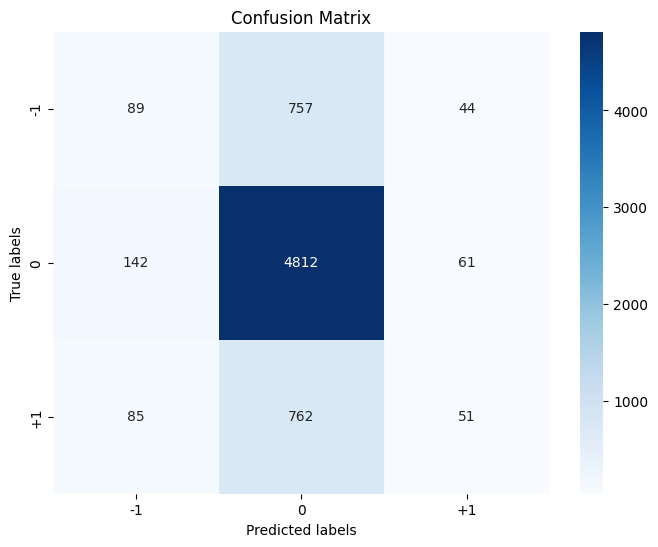

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Confusion report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '+1'], 
            yticklabels=['-1', '0', '+1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**Interpretation & Conclusion:**

- The model is performing particularly well for the class `0` (with an F1-score of 85%), which is the majority class given its large support.
- However, its performance on classes `-1` and `+1` is **weak**, with low F1-scores of 15% and 10%, respectively.
- The large difference between the macro and weighted F1-scores indicates that the model's overall performance is being driven primarily by its ability to classify the majority class (0.0) and less so the minority classes (-1.0 and 1.0).
- There may be a need to focus on techniques to **improve classification for the minority classes**, such as resampling, using different model architectures, or applying class weights.

This model is definitely can't use as indicator for trading strategy. However, it's a good start to explore more features and models.

----